* can be used to find nearby yelpers and target them with deal and specials, information can be sold to businesses

* win for business, yelp, and yelper

# EDA

<b>Objective:</b> To explore the Yelp datasets to derive insights from the data.

<b>Some initial questions:</b>
* Which businesses are getting top reviews?
* Which categories of business are getting top reviews?
* How businesses are getting reviewed over time.
<br>
* Are the categories of tending businesses different from top reviewed businesses?
* Which categories of businesses are new?
* Which categories of businesses are getting bad reviews?
<br>
* What are most common words in positive reviews?
* What are most common words in bad reviews?

<b>Terminology used:</b>

* Top reviewed business : Business with most numbers of positive reviews
* Negatively reviewed business : Business with most numbers of negative reviews
* Trending business : Business with most number of reviews, with more than 4 stars in recent years
* Positive review : Review > 3 stars
* Neutral review: Review = 3 stars
* Negative review : Review < 3 stars

In [3]:
# import databricks.koalas as ks
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import time
import json
import os
import pickle
from collections import Counter

import pyspark as ps

import pandas_profiling
# df.profile_report(style={'full_width':True})
# df.profile_report(title='Pandas Profiling Report')

import matplotlib.pyplot as plt

plt.style.use('seaborn-pastel')
font = {'size':16}
import seaborn as sns

import scipy.stats as scs

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import warnings
# warnings.simplefilter('ignore')


## Load data into memory

In [45]:
master_df = pd.read_pickle('../data/master_df.pkl')
print(master_df.shape)
master_df.head(2)

(4201684, 31)


business_id                      name_x  \
0  QXAEGFB4oINsVuTFxEYKFQ  Emerald Chinese Restaurant   
1  NX1281ugzs2navHAX5X9cQ                  Cha Me Cha   

                         address         city state postal_code   latitude  \
0           30 Eglinton Avenue W  Mississauga    ON     L5R 3E7  43.605499   
1  8333 Kennedy Road, Suite 1078      Markham    ON     L3R 1J5  43.856327   

   longitude  stars_x  review_count_x  is_open  \
0 -79.652289      2.5             128        1   
1 -79.303884      3.0             293        1   

                                          attributes  \
0  {'RestaurantsReservations': 'True', 'GoodForMe...   
1  {'OutdoorSeating': 'False', 'RestaurantsPriceR...   

                                          categories  \
0  [Specialty Food, Restaurants, Dim Sum, Importe...   
1  [Bubble Tea, Food, Restaurants, Taiwanese, Cof...   

                                               hours               review_id  \
0  {'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...  6W0MQHmasK0IsaoDo4bmkw   
1  {'Monday': '12:0-0:0', 'Tuesday': '12:0-0:0', ...  wbRQarYt_jBHNleOr0e1ng   

                  user_id  stars_y  useful  funny  cool  \
0  2K62MJ4CJ19L8Tp5pRfjfQ      3.0       3      2     0   
1  2K62MJ4CJ19L8Tp5pRfjfQ      4.0       1      0     0   

                                                text                 date  \
0  My girlfriend and I went for dinner at Emerald...  2017-01-27 21:54:30   
1  We decided to make a stop at Cha Me Cha for a ...  2018-08-20 21:38:43   

  name_y  review_count_y        yelping_since  \
0  David              57  2014-11-27 22:36:00   
1  David              57  2014-11-27 22:36:00   

                                             friends  fans  average_stars  \
0  ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...     1            3.3   
1  ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...     1            3.3   

   likes  compliments  elite_years  
0    100           16            2  
1    100           16            2

# Exploring the data

### Looking at businesses with highest number of reviews

In [3]:
business_review_count = master_df.groupby(['state', 'city', 'name_x', 'business_id'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
business_review_count = business_review_count.reset_index()
business_review_count.head(10)

state       city                         name_x             business_id  \
0    NV  Las Vegas                   Mon Ami Gabi  4JNXUYY8wbaaDmk3BPzlWw   
1    NV  Las Vegas               Bacchanal Buffet  RESDUcs7fIiihp38-d6_6g   
2    NV  Las Vegas                   Wicked Spoon  K7lWdNUhCbcnEvI0NhGewg   
3    NV  Las Vegas             Hash House A Go Go  f4x1YBxkLrZg652xt2KR5g   
4    NV  Las Vegas            Gordon Ramsay BurGR  cYwJA2A6I12KNkm2rtXd5g   
5    NV  Las Vegas               Earl of Sandwich  DkYS3arLOhA8si5uUEmHOw   
6    NV  Las Vegas                     The Buffet  2weQS-RnoOBhb1KsHKyoSQ   
7    NV  Las Vegas  The Cosmopolitan of Las Vegas  5LNZ67Yw9RD6nf4_UhXOjw   
8    NV  Las Vegas                   Secret Pizza  iCQpiavjjPzJ5_3gPD5Ebg   
9    NV  Las Vegas         The Buffet at Bellagio  ujHiaprwCQ5ewziu0Vi9rw   

   review_id  
0       8570  
1       8568  
2       6887  
3       5847  
4       5575  
5       5206  
6       4534  
7       4522  
8       4351  
9       4318

### Remove 'Hotels'

it looks like there are hotels mixed in with the reviews, let's remove the businesses with 'hotel' in the category most of them are not restaurants yet are highly reviewed

In [46]:
# look at businesses with 'Hotels' in categories

master_df['hotel?'] = master_df['categories'].apply(lambda x: 1 if 'Hotels' in x else 0)
master_df[master_df['hotel?'] == 1].shape

(89929, 32)

### removing 282 'Hotels'

In [49]:
# Remove 'Hotels' from df

master_df = master_df[master_df['hotel?'] == 0]
master_df.shape

(4111755, 32)

## to_csv for tableau

### Count of (<font color = 'green'>Positive</font> / <font color = 'tan'>Neutral</font> / <font color = 'red'>Negative</font>) Reviews by City

In [7]:
master_df['positive_review'] = master_df['stars_x'] > 3
master_df['neutral_review'] = master_df['stars_x'] == 3
master_df['negative_review'] = master_df['stars_x'] < 3

review_by_statecity = master_df.groupby(['state', 'city'])['review_id', 'positive_review', 'neutral_review', 'negative_review'].sum().astype('int')
review_by_statecity['review_count'] = review_by_statecity['positive_review'] + review_by_statecity['neutral_review'] + review_by_statecity['negative_review']
review_by_statecity['positive_ratio'] = review_by_statecity['positive_review'] / review_by_statecity['review_count']
review_by_statecity['positive_ratio'] = review_by_statecity['positive_ratio'].map('{:,.2f}'.format)
review_by_statecity.sort_values(by='review_count', axis=0, ascending=False, inplace=True)
review_by_statecity.reset_index(inplace=True)

In [8]:
review_by_statecity.sort_values(by='review_count', axis=0, ascending=False, inplace=True)
review_by_statecity.head(10)

state        city  positive_review  neutral_review  negative_review  \
0    NV   Las Vegas           989528          118729            61930   
1    AZ     Phoenix           361686           37247            24303   
2    ON     Toronto           288501           61571            24980   
3    AZ  Scottsdale           201330           18897             6799   
4    NC   Charlotte           166510           25275            16184   
5    PA  Pittsburgh           134199           18742             8518   
6    AZ       Tempe            94266           15081             7778   
7    QC    Montréal           102816            8446             5375   
8    NV   Henderson            90952           11240             8211   
9    AZ        Mesa            69549           11541             8338   

   review_count positive_ratio  
0       1170187           0.85  
1        423236           0.85  
2        375052           0.77  
3        227026           0.89  
4        207969           0.80  
5        161459           0.83  
6        117125           0.80  
7        116637           0.88  
8        110403           0.82  
9         89428           0.78

### Cities with largest number of reviews

In [6]:
city_review_count = master_df.groupby(['state', 'city'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
city_review_count = city_review_count.reset_index()
city_review_count.head(20)

state             city  review_id
0     NV        Las Vegas    1170187
1     AZ          Phoenix     423236
2     ON          Toronto     375052
3     AZ       Scottsdale     227026
4     NC        Charlotte     207969
5     PA       Pittsburgh     161459
6     AZ            Tempe     117125
7     QC         Montréal     116637
8     NV        Henderson     110403
9     AZ             Mesa      89428
10    AZ         Chandler      87723
11    OH        Cleveland      81940
12    WI          Madison      73884
13    AZ          Gilbert      70136
14    AB          Calgary      62634
15    AZ         Glendale      56209
16    ON      Mississauga      41451
17    ON          Markham      39822
18    AZ           Peoria      30319
19    NV  North Las Vegas      24870

### States with largest number of reviews

In [7]:
state_review_count = master_df.groupby(['state'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
state_review_count = state_review_count.reset_index()
state_review_count.head(10)

state  review_id
0    NV    1316216
1    AZ    1182595
2    ON     572347
3    NC     272087
4    OH     226048
5    PA     203716
6    QC     137403
7    WI      93201
8    AB      63886
9    IL      28689

## Plot Cities on map

In [49]:
csv_df = master_df[['business_id','name_x', 'city', 'state', 'postal_code', 'latitude', 'longitude']]
csv_df.head()

business_id                      name_x           city state  \
0  QXAEGFB4oINsVuTFxEYKFQ  Emerald Chinese Restaurant    Mississauga    ON   
1  NX1281ugzs2navHAX5X9cQ                  Cha Me Cha        Markham    ON   
2  5H4coiGpvG3XdnU1Nde2xQ          Keung's Restaurant        Markham    ON   
3  SvMBtzXfE-3H5pxoR7VD3w             Kenny's Gourmet  Richmond Hill    ON   
4  PFAvETr4Vf6UY548TWvhFA      Koi Sakana Ramen House  Richmond Hill    ON   

  postal_code   latitude  longitude  
0     L5R 3E7  43.605499 -79.652289  
1     L3R 1J5  43.856327 -79.303884  
2     L3R 0W4  43.860726 -79.304713  
3         L3R  43.883345 -79.388160  
4     L4B 3Y7  43.841523 -79.397015

In [50]:
csv_df.to_csv('../data/csv_df_no_hotel.csv')

<div class='tableauPlaceholder' id='viz1563838423881' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;7T&#47;7TWW6J6KG&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;7TWW6J6KG' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;7T&#47;7TWW6J6KG&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1563838423881');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## Visualization of dataset - US businesses

https://public.tableau.com/shared/F6SF2YBT3?:display_count=yes&:origin=viz_share_link
            
<img src = '../img/us_location_viz.png'>

#### Looks like there are 7 major circles

* let's focus on looking into the two bigger circles (Arizona and Nevada) as they have lots of reviews and are close in proximity to each other location wise.

### Looking into Nevada restaurants

In [55]:
vegas_reviews = master_df.groupby(['state', 'city', 'name_x', 'business_id'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
vegas_reviews = vegas_reviews.reset_index()
vegas_reviews = vegas_reviews[vegas_reviews['state'] == 'NV']
vegas_reviews.head(10)

state       city                  name_x             business_id  review_id
0    NV  Las Vegas            Mon Ami Gabi  4JNXUYY8wbaaDmk3BPzlWw       8570
1    NV  Las Vegas        Bacchanal Buffet  RESDUcs7fIiihp38-d6_6g       8568
2    NV  Las Vegas            Wicked Spoon  K7lWdNUhCbcnEvI0NhGewg       6887
3    NV  Las Vegas      Hash House A Go Go  f4x1YBxkLrZg652xt2KR5g       5847
4    NV  Las Vegas     Gordon Ramsay BurGR  cYwJA2A6I12KNkm2rtXd5g       5575
5    NV  Las Vegas        Earl of Sandwich  DkYS3arLOhA8si5uUEmHOw       5206
6    NV  Las Vegas            Secret Pizza  iCQpiavjjPzJ5_3gPD5Ebg       4351
7    NV  Las Vegas  The Buffet at Bellagio  ujHiaprwCQ5ewziu0Vi9rw       4318
8    NV  Las Vegas           Lotus of Siam  KskYqH1Bi7Z_61pH6Om8pg       4131
9    NV  Las Vegas                 Bouchon  rcaPajgKOJC2vo_l3xa42A       4014

### Looking into Arizona restaurants

In [57]:
arizona_reviews = master_df.groupby(['state', 'city', 'name_x', 'business_id'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
arizona_reviews = arizona_reviews.reset_index()
arizona_reviews = arizona_reviews[arizona_reviews['state'] == 'AZ']
arizona_reviews.head(20)

state        city                      name_x             business_id  \
30     AZ     Phoenix                     Bobby Q  VyVIneSU7XAWgMBllI6LnQ   
44     AZ     Phoenix             Pizzeria Bianco  pSQFynH1VxkfSmehRXlZWw   
49     AZ       Tempe          Four Peaks Brewing  JzOp695tclcNCNMuBl7oxA   
53     AZ  Scottsdale        Rehab Burger Therapy  3l54GTr8-E3XPbIxnF_sAA   
54     AZ     Phoenix                 Lux Central  OgJ0KxwJcJ9R5bUK0ixCbg   
55     AZ     Gilbert            Joe's Farm Grill  0FUtlsQrJI7LhqDPxLumEw   
58     AZ     Phoenix                La Santisima  frCxZS7lPhEnQRJ3UY6m7A   
60     AZ     Phoenix        The Arrogant Butcher  yNPh5SO-7wr8HPpVCDPbXQ   
61     AZ     Phoenix                        Cibo  9a3DrZvpYxVs3k_qwlCNSw   
62     AZ     Phoenix             Little Miss BBQ  Xg5qEQiB-7L6kGJ5F4K3bQ   
64     AZ  Scottsdale        The Mission Old Town  K-uQkfSUTwu5LIwPB4b_vg   
68     AZ     Phoenix   Lo-Lo's Chicken & Waffles  YPavuOh2XsnRbLfl0DH2lQ   
70     AZ  Scottsdale                 Olive & Ivy  wUKzaS1MHg94RGM6z8u9mw   
72     AZ  Scottsdale        Citizen Public House  d10IxZPirVJlOSpdRZJczA   
75     AZ     Phoenix        Matt's Big Breakfast  L2p0vO3fsS2LC6hhQo3CzA   
90     AZ       Tempe               Cornish Pasty  wl0QZqAzr1DelslQ02JGCQ   
96     AZ     Phoenix               Chino Bandido  cHdJXLlKNWixBXpDwEGb_A   
104    AZ     Phoenix      St. Francis Restaurant  z6-reuC5BYf_Rth9gMBfgQ   
109    AZ     Phoenix  Pappadeaux Seafood Kitchen  whAwdYVty-jSNRhrYT2zHA   
113    AZ     Phoenix                  Taco Guild  3C5Z9homtzkWHouH2BHXYQ   

     review_id  
30        2662  
44        2320  
49        2258  
53        2136  
54        2114  
55        2097  
58        2020  
60        2006  
61        2005  
62        1982  
64        1950  
68        1859  
70        1842  
72        1838  
75        1823  
90        1662  
96        1636  
104       1584  
109       1572  
113       1524

### User reviews by unique city

In [ ]:
user_city_count = master_df.groupby(['state', 'city'])['user_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
user_city_count = user_city_count.reset_index()
user_city_count.head(10)

state        city  user_id
0    NV   Las Vegas  1170187
1    AZ     Phoenix   423236
2    ON     Toronto   375052
3    AZ  Scottsdale   227026
4    NC   Charlotte   207969
5    PA  Pittsburgh   161459
6    AZ       Tempe   117125
7    QC    Montréal   116637
8    NV   Henderson   110403
9    AZ        Mesa    89428

### # of reviews by user from this dataset

In [5]:
user_review_count = master_df.groupby(['user_id'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
user_review_count = user_review_count.reset_index()
user_review_count = user_review_count.rename(columns={"review_id": "review_total"})
print(user_review_count.shape)
user_review_count.head(2)

(1123227, 2)


user_id  review_total
0  CxDOIDnH8gp9KXzpBHJYXw          2653
1  bLbSNkLggFnqwNNzzq-Ijw          1516

## ratio of users and % of what city they review

In [6]:
user_city_review_count = master_df.groupby(['state', 'city', 'user_id'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
user_city_review_count = user_city_review_count.reset_index()
user_city_review_count = user_city_review_count.rename(columns={"review_id": "review_by_city"})
print(user_city_review_count.shape)
user_city_review_count.head(2)

(1648624, 4)


state       city                 user_id  review_by_city
0    NV  Las Vegas  bLbSNkLggFnqwNNzzq-Ijw            1363
1    ON    Toronto  CxDOIDnH8gp9KXzpBHJYXw            1070

In [9]:
user_city_review_ratio = user_city_review_count.merge(user_review_count, on='user_id')
user_city_review_ratio['ratio'] = user_city_review_ratio['review_by_city']/user_city_review_ratio['review_total']
print(user_city_review_ratio.shape)
user_city_review_ratio.head(10)

(1648624, 6)


state             city                 user_id  review_by_city  \
0    NV        Las Vegas  bLbSNkLggFnqwNNzzq-Ijw            1363   
1    NV        Henderson  bLbSNkLggFnqwNNzzq-Ijw              94   
2    NV  North Las Vegas  bLbSNkLggFnqwNNzzq-Ijw              23   
3    AZ          Phoenix  bLbSNkLggFnqwNNzzq-Ijw              15   
4    NV     Boulder City  bLbSNkLggFnqwNNzzq-Ijw               8   
5    AZ          Gilbert  bLbSNkLggFnqwNNzzq-Ijw               5   
6    AZ            Tempe  bLbSNkLggFnqwNNzzq-Ijw               3   
7    NV       Las  Vegas  bLbSNkLggFnqwNNzzq-Ijw               2   
8    AZ       Scottsdale  bLbSNkLggFnqwNNzzq-Ijw               1   
9    NV     Blue Diamond  bLbSNkLggFnqwNNzzq-Ijw               1   

   review_total     ratio  
0          1516  0.899077  
1          1516  0.062005  
2          1516  0.015172  
3          1516  0.009894  
4          1516  0.005277  
5          1516  0.003298  
6          1516  0.001979  
7          1516  0.001319  
8          1516  0.000660  
9          1516  0.000660

In [42]:
user_city_review_ratio.head(10000)

state                            city                 user_id  \
0       NV                       Las Vegas  bLbSNkLggFnqwNNzzq-Ijw   
1       NV                       Henderson  bLbSNkLggFnqwNNzzq-Ijw   
2       NV                 North Las Vegas  bLbSNkLggFnqwNNzzq-Ijw   
3       AZ                         Phoenix  bLbSNkLggFnqwNNzzq-Ijw   
4       NV                    Boulder City  bLbSNkLggFnqwNNzzq-Ijw   
5       AZ                         Gilbert  bLbSNkLggFnqwNNzzq-Ijw   
6       AZ                           Tempe  bLbSNkLggFnqwNNzzq-Ijw   
7       NV                      Las  Vegas  bLbSNkLggFnqwNNzzq-Ijw   
8       AZ                      Scottsdale  bLbSNkLggFnqwNNzzq-Ijw   
9       NV                    Blue Diamond  bLbSNkLggFnqwNNzzq-Ijw   
10      NV                       Summerlin  bLbSNkLggFnqwNNzzq-Ijw   
11      ON                         Toronto  CxDOIDnH8gp9KXzpBHJYXw   
12      ON                         Markham  CxDOIDnH8gp9KXzpBHJYXw   
13      ON                   Richmond Hill  CxDOIDnH8gp9KXzpBHJYXw   
14      ON                     Scarborough  CxDOIDnH8gp9KXzpBHJYXw   
15      ON                         Vaughan  CxDOIDnH8gp9KXzpBHJYXw   
16      ON                      North York  CxDOIDnH8gp9KXzpBHJYXw   
17      ON                       Thornhill  CxDOIDnH8gp9KXzpBHJYXw   
18      QC                        Montréal  CxDOIDnH8gp9KXzpBHJYXw   
19      ON                     Mississauga  CxDOIDnH8gp9KXzpBHJYXw   
20      ON                       Newmarket  CxDOIDnH8gp9KXzpBHJYXw   
21      ON                      Unionville  CxDOIDnH8gp9KXzpBHJYXw   
22      ON                       Pickering  CxDOIDnH8gp9KXzpBHJYXw   
23      ON                      Woodbridge  CxDOIDnH8gp9KXzpBHJYXw   
24      ON                          Whitby  CxDOIDnH8gp9KXzpBHJYXw   
25      ON                         Concord  CxDOIDnH8gp9KXzpBHJYXw   
26      ON                       Etobicoke  CxDOIDnH8gp9KXzpBHJYXw   
27      ON          Whitchurch-Stouffville  CxDOIDnH8gp9KXzpBHJYXw   
28      ON                        Brampton  CxDOIDnH8gp9KXzpBHJYXw   
29      ON                          Aurora  CxDOIDnH8gp9KXzpBHJYXw   
30      ON                     Stouffville  CxDOIDnH8gp9KXzpBHJYXw   
31      AB                         Calgary  CxDOIDnH8gp9KXzpBHJYXw   
32      OH                       Cleveland  CxDOIDnH8gp9KXzpBHJYXw   
33      PA                      Pittsburgh  CxDOIDnH8gp9KXzpBHJYXw   
34      ON                            Ajax  CxDOIDnH8gp9KXzpBHJYXw   
35      ON                           Maple  CxDOIDnH8gp9KXzpBHJYXw   
36      ON                       East York  CxDOIDnH8gp9KXzpBHJYXw   
37      ON                        Oakville  CxDOIDnH8gp9KXzpBHJYXw   
38      ON                          Bolton  CxDOIDnH8gp9KXzpBHJYXw   
39      ON                        Goodwood  CxDOIDnH8gp9KXzpBHJYXw   
40      ON                            King  CxDOIDnH8gp9KXzpBHJYXw   
41      ON                       Kleinburg  CxDOIDnH8gp9KXzpBHJYXw   
42      ON                East Gwillimbury  CxDOIDnH8gp9KXzpBHJYXw   
43      ON   Regional Municipality of York  CxDOIDnH8gp9KXzpBHJYXw   
44      ON                       Schomberg  CxDOIDnH8gp9KXzpBHJYXw   
45      ON                        Thornhil  CxDOIDnH8gp9KXzpBHJYXw   
46      NV                       Las Vegas  PKEzKWv_FktMm2mGPjwd0Q   
47      NV                       Henderson  PKEzKWv_FktMm2mGPjwd0Q   
48      NV                    Boulder City  PKEzKWv_FktMm2mGPjwd0Q   
49      NV                 North Las Vegas  PKEzKWv_FktMm2mGPjwd0Q   
50      NV                    Blue Diamond  PKEzKWv_FktMm2mGPjwd0Q   
51      NV                      Las  Vegas  PKEzKWv_FktMm2mGPjwd0Q   
52      NV                       Summerlin  PKEzKWv_FktMm2mGPjwd0Q   
53      NV                       Las Vegas  U4INQZOPSUaj8hMjLlZ3KA   
54      AZ                         Phoenix  U4INQZOPSUaj8hMjLlZ3KA   
55      NV                       Henderson  U4INQZOPSUaj8hMjLlZ3KA   
56      AZ     

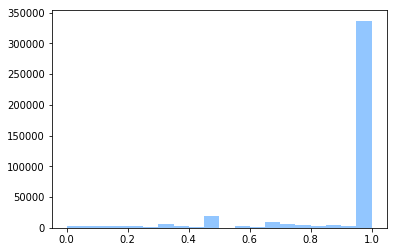

In [38]:
vegas_user_city_review_ratio = user_city_review_ratio[user_city_review_ratio['city']=='Las Vegas']
vegas_user_city_review_ratio = vegas_user_city_review_ratio[vegas_user_city_review_ratio['state']=='NV']
plt.hist(vegas_user_city_review_ratio['ratio'], bins=20)
plt.show();

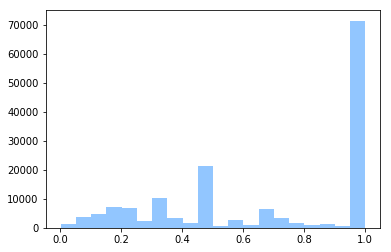

In [39]:
phoenix_user_city_review_ratio = user_city_review_ratio[user_city_review_ratio['city']=='Phoenix']
phoenix_user_city_review_ratio = phoenix_user_city_review_ratio[phoenix_user_city_review_ratio['state']=='AZ']
plt.hist(phoenix_user_city_review_ratio['ratio'], bins=20)
plt.show();

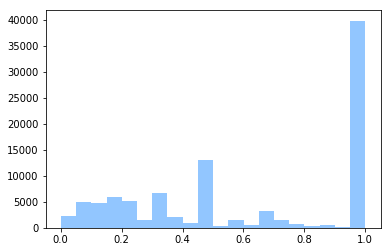

In [40]:
scottsdale_user_city_review_ratio = user_city_review_ratio[user_city_review_ratio['city']=='Scottsdale']
scottsdale_user_city_review_ratio = scottsdale_user_city_review_ratio[scottsdale_user_city_review_ratio['state']=='AZ']
plt.hist(scottsdale_user_city_review_ratio['ratio'], bins=20)
plt.show();

In [ ]:
state_filter_list = ['NV', 'AZ', 'ON', 'NC']
city_filter_list = ['Las Vegas', 'Phoenix', 'Toronto', 'Scottsdale', 'Charlotte']

top5_reviews = master_df.groupby(['state', 'city', 'name_x', 'business_id'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
top5_reviews = top5_reviews.reset_index()
top5_reviews = top5_reviews[top5_reviews['state'].isin(state_filter_list)]
top5_reviews = top5_reviews[top5_reviews['city'].isin(city_filter_list)]
top5_reviews.head()

## Creating Arizona and Nevada Dataset

In [50]:
master_df.shape

(4111755, 32)

In [51]:
state_filter_list = ['NV', 'AZ']

AZNV_df = master_df[master_df['state'].isin(state_filter_list)]
AZNV_df = AZNV_df.reset_index(drop=True)
print('Shape of AZNV_df: {}'.format(AZNV_df.shape))
AZNV_df.head()

Shape of AZNV_df: (2498811, 32)


business_id                            name_x  \
0  vx4YAA02Qz6khRD1fZ1MFA                    Ping Pang Pong   
1  glTBzDHv9wNhEsZa4bQrOA       CatHouse Boutique Nightclub   
2  8Q6jl7OW8DZzwANggDspcw  Sugar Factory American Brasserie   
3  41b2SLmjLcxTGLVRxASiDA                      Country Club   
4  Ehy00JWQixgoXzisVKhvag           Cucina by Wolfgang Puck   

                                        address       city state postal_code  \
0                            4000 W Flamingo Rd  Las Vegas    NV       89103   
1                         3900 Las Vegas Blvd S  Las Vegas    NV       89119   
2  Paris Las Vegas Hotel, 3655 Las Vegas Blvd S  Las Vegas    NV       89109   
3                         3131 Las Vegas Blvd S  Las Vegas    NV       89109   
4                         3720 S Las Vegas Blvd  Las Vegas    NV       89158   

    latitude   longitude  stars_x  review_count_x  is_open  \
0  36.116901 -115.193512      3.5            1005        1   
1  36.094822 -115.173216      3.0             178        0   
2  36.112015 -115.172532      3.0             745        0   
3  36.126720 -115.163553      4.0             269        0   
4  36.107677 -115.175062      4.0             921        1   

                                          attributes  \
0  {'RestaurantsPriceRange2': '2', 'BusinessAccep...   
1  {'OutdoorSeating': 'False', 'BusinessAcceptsCr...   
2  {'RestaurantsDelivery': 'False', 'RestaurantsA...   
3  {'RestaurantsAttire': 'u'dressy'', 'Restaurant...   
4  {'RestaurantsDelivery': 'False', 'RestaurantsP...   

                                          categories  \
0  [Cantonese, Seafood, Dim Sum, Restaurants, Chi...   
1  [Restaurants, Nightlife, Lounges, American (Ne...   
2  [Brasseries, Bars, Breakfast & Brunch, Food, C...   
3  [Restaurants, Breakfast & Brunch, Seafood, Ame...   
4                      [Restaurants, Italian, Pizza]   

                                               hours               review_id  \
0  {'Monday': '10:0-3:0', 'Tuesday': '10:0-3:0', ...  FwiJ7DQ3a9cBwp1OYlP5VA   
1  {'Monday': '17:0-4:0', 'Tuesday': '17:0-4:0', ...  7ynnTyXiuIWHDkktHsdm4Q   
2  {'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...  lO_55KRKtw2Rv1ZIHflX2w   
3  {'Monday': '0:0-0:0', 'Tuesday': '11:30-14:30'...  0WHDB3dNcUsybN4zRJbFzw   
4  {'Monday': '11:30-22:0', 'Tuesday': '11:30-22:...  tL3FZuCRK4q4d_bAF-VDOQ   

                  user_id  stars_y  useful  funny  cool  \
0  A0kENtCCoVT3m7T35zb2Vg      2.0       0      0     0   
1  A0kENtCCoVT3m7T35zb2Vg      2.0       1      1     0   
2  A0kENtCCoVT3m7T35zb2Vg      1.0       0      0     0   
3  A0kENtCCoVT3m7T35zb2Vg      4.0       0      0     0   
4  A0kENtCCoVT3m7T35zb2Vg      5.0       0      0     0   

                                                text                 date  \
0  There are so many good reviews of this place o...  2010-04-02 20:37:54   
1  Restaurant-only review; based on that, they wo...  2009-02-16 14:53:11   
2  Are you allowed to post the phrase "sh*t show"...  2012-04-26 01:23:24   
3  Our party of six enjoyed the Sunday jazz brunc...  2011-04-27 00:35:55   
4  This was the best surprise of our recent trip ...  2012-04-26 01:11:46   

      name_y  review_count_y        yelping_since  \
0  Anastasia             348  2009-02-15 16:45:34   
1  Anastasia             348  2009-02-15 16:45:34   
2  Anastasia             348  2009-02-15 16:45:34   
3  Anastasia             348  2009-02-15 16:45:34   
4  Anastasia             348  2009-02-15 16:45:34   

                                             friends  fans  average_stars  \
0  BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...     9           3.66   
1  BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...     9           3.66   
2  BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...     9           3.66   
3  BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...     9           3.66   
4  BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...     9           3.66   

   likes  compliments  eli

In [53]:
print('Excluding all cities except those from Arizona and Nevada reduces our dataset by {:,} rows'.format(master_df.shape[0]-AZNV_df.shape[0]))

Excluding all cities except those from Arizona and Nevada reduces our dataset by 1,612,944 rows


### Look at Data Density

min: 1
max: 1516


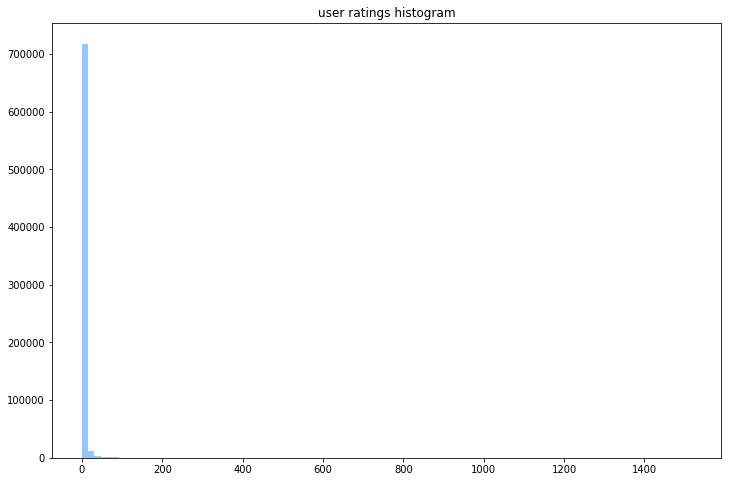

In [132]:
user_rating_count = AZNV_df.groupby('user_id').count()

fig, ax = plt.subplots(1, figsize = (12, 8))
a = ax.hist(user_rating_count['business_id'], bins=100)
a = ax.set_title('user ratings histogram')

print('min: {}'.format(min(user_rating_count['business_id'])))
print('max: {}'.format(max(user_rating_count['business_id'])))

min: 3
max: 8570


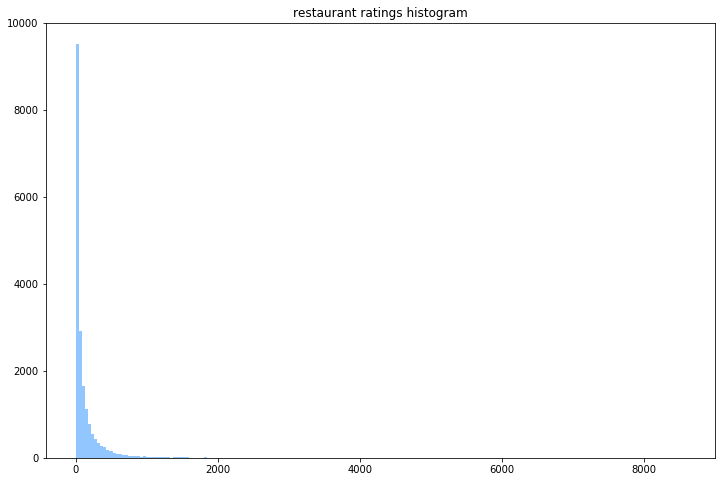

In [133]:
restaurant_rating_count = AZNV_df.groupby('business_id').count()

fig, ax = plt.subplots(1, figsize = (12, 8))
a = ax.hist(restaurant_rating_count['user_id'], bins=200)
a = ax.set_title('restaurant ratings histogram')

print('min: {}'.format(min(restaurant_rating_count['user_id'])))
print('max: {}'.format(max(restaurant_rating_count['user_id'])))

In [134]:
rated_items = sum(restaurant_rating_count['user_id'])
print(rated_items)
num_items = len(restaurant_rating_count['user_id'])
print(num_items)
num_users = len(user_rating_count['business_id'])
print(num_users)

print('\nThe density of our data is {:.5f}'.format(rated_items/(num_items*num_users)))

2498811
19094
737922

The density of our data is 0.00018


#### This is a poor density score, let's bring this number up

In [135]:
users_review = 1
removed_reviews = 0

print('total reviews: {:,}'.format(rated_items))

for i in range(6):
    removed_reviews = removed_reviews + len(user_rating_count[user_rating_count['business_id']==users_review])*users_review 
    print('removing users with <= {} reviews would remove {:,} or {:.2%} reviews from the dataset'.format(users_review, removed_reviews, removed_reviews/rated_items))
    users_review+=1

total reviews: 2,498,811
removing users with <= 1 reviews would remove 410,187 or 16.42% reviews from the dataset
removing users with <= 2 reviews would remove 658,927 or 26.37% reviews from the dataset
removing users with <= 3 reviews would remove 839,254 or 33.59% reviews from the dataset
removing users with <= 4 reviews would remove 979,986 or 39.22% reviews from the dataset
removing users with <= 5 reviews would remove 1,093,571 or 43.76% reviews from the dataset
removing users with <= 6 reviews would remove 1,186,715 or 47.49% reviews from the dataset


#### Remove users <= 3 reviews

In [10]:
remove_users = user_rating_count[user_rating_count['business_id']<=3].index.values

In [11]:
AZNV_df = AZNV_df[~AZNV_df['user_id'].isin(remove_users)]
print(AZNV_df.shape)
AZNV_df.head(2)

(1635741, 32)


business_id                       name_x                address  \
0  vx4YAA02Qz6khRD1fZ1MFA               Ping Pang Pong     4000 W Flamingo Rd   
1  glTBzDHv9wNhEsZa4bQrOA  CatHouse Boutique Nightclub  3900 Las Vegas Blvd S   

        city state postal_code   latitude   longitude  stars_x  \
0  Las Vegas    NV       89103  36.116901 -115.193512      3.5   
1  Las Vegas    NV       89119  36.094822 -115.173216      3.0   

   review_count_x  is_open                                         attributes  \
0            1005        1  {'RestaurantsPriceRange2': '2', 'BusinessAccep...   
1             178        0  {'OutdoorSeating': 'False', 'BusinessAcceptsCr...   

                                          categories  \
0  [Cantonese, Seafood, Dim Sum, Restaurants, Chi...   
1  [Restaurants, Nightlife, Lounges, American (Ne...   

                                               hours               review_id  \
0  {'Monday': '10:0-3:0', 'Tuesday': '10:0-3:0', ...  FwiJ7DQ3a9cBwp1OYlP5VA   
1  {'Monday': '17:0-4:0', 'Tuesday': '17:0-4:0', ...  7ynnTyXiuIWHDkktHsdm4Q   

                  user_id  stars_y  useful  funny  cool  \
0  A0kENtCCoVT3m7T35zb2Vg      2.0       0      0     0   
1  A0kENtCCoVT3m7T35zb2Vg      2.0       1      1     0   

                                                text                 date  \
0  There are so many good reviews of this place o...  2010-04-02 20:37:54   
1  Restaurant-only review; based on that, they wo...  2009-02-16 14:53:11   

      name_y  review_count_y        yelping_since  \
0  Anastasia             348  2009-02-15 16:45:34   
1  Anastasia             348  2009-02-15 16:45:34   

                                             friends  fans  average_stars  \
0  BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...     9           3.66   
1  BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...     9           3.66   

   likes  compliments  elite_years  hotel?  
0    619           38            3       0  
1    619           38            3       0

### Look at matrix density

min: 4
max: 1473


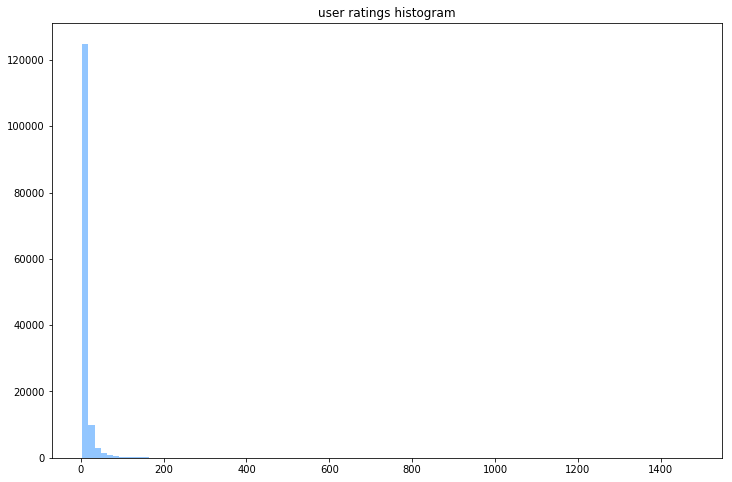

In [12]:
user_rating_count = AZNV_df.groupby('user_id').count()

fig, ax = plt.subplots(1, figsize = (12, 8))
a = ax.hist(user_rating_count['business_id'], bins=100)
a = ax.set_title('user ratings histogram')

print('min: {}'.format(min(user_rating_count['business_id'])))
print('max: {}'.format(max(user_rating_count['business_id'])))

min: 4
max: 4399


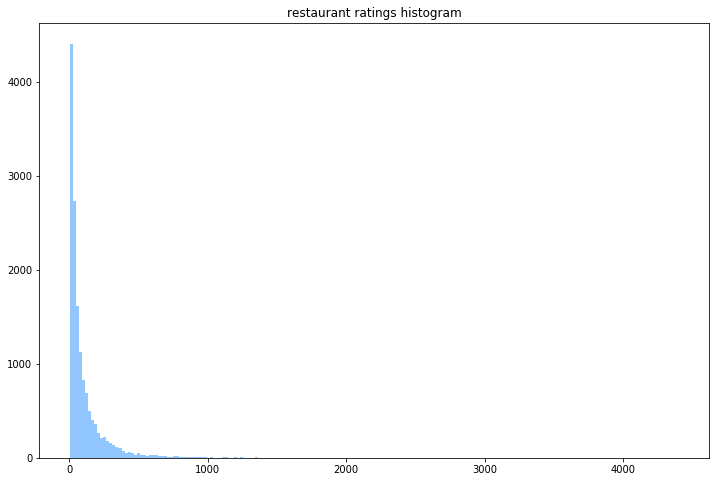

In [13]:
restaurant_rating_count = AZNV_df.groupby('business_id').count()

fig, ax = plt.subplots(1, figsize = (12, 8))
a = ax.hist(restaurant_rating_count['user_id'], bins=200)
a = ax.set_title('restaurant ratings histogram')

print('min: {}'.format(min(restaurant_rating_count['user_id'])))
print('max: {}'.format(max(restaurant_rating_count['user_id'])))

In [14]:
rated_items = sum(restaurant_rating_count['user_id'])
print(rated_items)
num_items = len(restaurant_rating_count['user_id'])
print(num_items)
num_users = len(user_rating_count['business_id'])
print(num_users)

print('\nThe density of our data is {:.5f}'.format(rated_items/(num_items*num_users)))

1635741
14797
141815

The density of our data is 0.00078


### Look at what # of businesses to remove to improve density

In [16]:
restaurant_review = 1
removed_reviews = 0

print('total reviews: {:,}'.format(rated_items))

for i in range(30):
    removed_reviews = removed_reviews + len(user_rating_count[user_rating_count['business_id']==restaurant_review])*restaurant_review 
    print('removing restaurants with <= {} reviews would remove {:,} or {:.2%} reviews from the dataset'.format(restaurant_review, removed_reviews, removed_reviews/rated_items))
    restaurant_review+=1

total reviews: 1,635,741
removing restaurants with <= 1 reviews would remove 0 or 0.00% reviews from the dataset
removing restaurants with <= 2 reviews would remove 0 or 0.00% reviews from the dataset
removing restaurants with <= 3 reviews would remove 0 or 0.00% reviews from the dataset
removing restaurants with <= 4 reviews would remove 139,404 or 8.52% reviews from the dataset
removing restaurants with <= 5 reviews would remove 252,124 or 15.41% reviews from the dataset
removing restaurants with <= 6 reviews would remove 344,524 or 21.06% reviews from the dataset
removing restaurants with <= 7 reviews would remove 424,303 or 25.94% reviews from the dataset
removing restaurants with <= 8 reviews would remove 491,535 or 30.05% reviews from the dataset
removing restaurants with <= 9 reviews would remove 550,836 or 33.68% reviews from the dataset
removing restaurants with <= 10 reviews would remove 604,286 or 36.94% reviews from the dataset
removing restaurants with <= 11 reviews would 

### Remove businesses with < 10 reviews

In [17]:
remove_restaurants = restaurant_rating_count[restaurant_rating_count['user_id']<10].index.values

In [18]:
AZNV_df = AZNV_df[~AZNV_df['business_id'].isin(remove_restaurants)]
print(AZNV_df.shape)
AZNV_df.head(2)

(1632367, 32)


business_id                       name_x                address  \
0  vx4YAA02Qz6khRD1fZ1MFA               Ping Pang Pong     4000 W Flamingo Rd   
1  glTBzDHv9wNhEsZa4bQrOA  CatHouse Boutique Nightclub  3900 Las Vegas Blvd S   

        city state postal_code   latitude   longitude  stars_x  \
0  Las Vegas    NV       89103  36.116901 -115.193512      3.5   
1  Las Vegas    NV       89119  36.094822 -115.173216      3.0   

   review_count_x  is_open                                         attributes  \
0            1005        1  {'RestaurantsPriceRange2': '2', 'BusinessAccep...   
1             178        0  {'OutdoorSeating': 'False', 'BusinessAcceptsCr...   

                                          categories  \
0  [Cantonese, Seafood, Dim Sum, Restaurants, Chi...   
1  [Restaurants, Nightlife, Lounges, American (Ne...   

                                               hours               review_id  \
0  {'Monday': '10:0-3:0', 'Tuesday': '10:0-3:0', ...  FwiJ7DQ3a9cBwp1OYlP5VA   
1  {'Monday': '17:0-4:0', 'Tuesday': '17:0-4:0', ...  7ynnTyXiuIWHDkktHsdm4Q   

                  user_id  stars_y  useful  funny  cool  \
0  A0kENtCCoVT3m7T35zb2Vg      2.0       0      0     0   
1  A0kENtCCoVT3m7T35zb2Vg      2.0       1      1     0   

                                                text                 date  \
0  There are so many good reviews of this place o...  2010-04-02 20:37:54   
1  Restaurant-only review; based on that, they wo...  2009-02-16 14:53:11   

      name_y  review_count_y        yelping_since  \
0  Anastasia             348  2009-02-15 16:45:34   
1  Anastasia             348  2009-02-15 16:45:34   

                                             friends  fans  average_stars  \
0  BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...     9           3.66   
1  BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...     9           3.66   

   likes  compliments  elite_years  hotel?  
0    619           38            3       0  
1    619           38            3       0

### Check Data Density again


We removed resturants <10 so we need to check user density to see if it is still > 3

min: 1
max: 1466


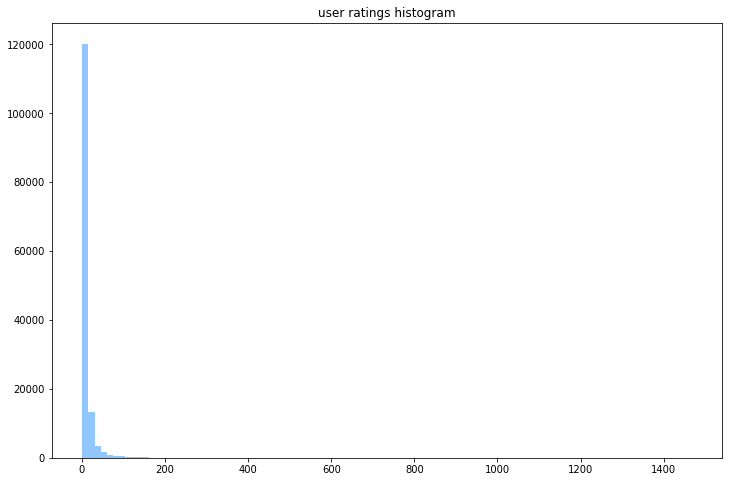

In [19]:
user_rating_count = AZNV_df.groupby('user_id').count()

fig, ax = plt.subplots(1, figsize = (12, 8))
a = ax.hist(user_rating_count['business_id'], bins=100)
a = ax.set_title('user ratings histogram')

print('min: {}'.format(min(user_rating_count['business_id'])))
print('max: {}'.format(max(user_rating_count['business_id'])))

min: 10
max: 4399


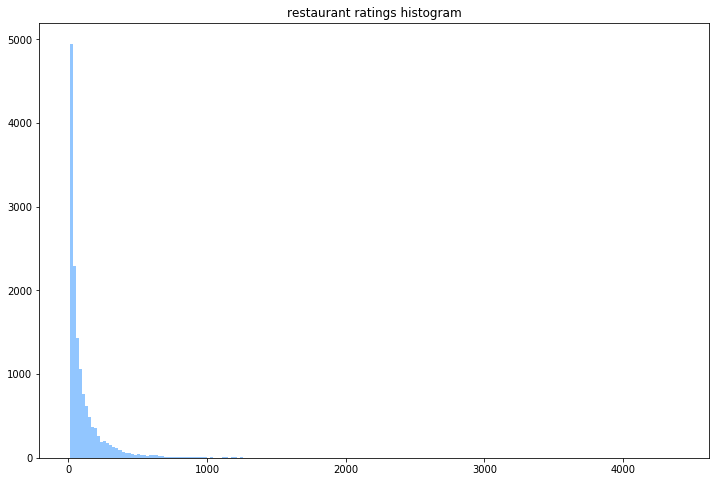

In [30]:
restaurant_rating_count = AZNV_df.groupby('business_id').count()

fig, ax = plt.subplots(1, figsize = (12, 8))
a = ax.hist(restaurant_rating_count['user_id'], bins=200)
a = ax.set_title('restaurant ratings histogram')

print('min: {}'.format(min(restaurant_rating_count['user_id'])))
print('max: {}'.format(max(restaurant_rating_count['user_id'])))

### The user review density did drop, let's look into this

In [22]:
users_review = 1
removed_reviews = 0

print('total current reviews: {:,}'.format(rated_items))

for i in range(8):
    removed_reviews = removed_reviews + len(user_rating_count[user_rating_count['business_id']==users_review])*users_review 
    print('removing users with <= {} reviews would remove {:,} or {:.2%} reviews from the dataset'.format(users_review, removed_reviews, removed_reviews/rated_items))
    users_review+=1

total current reviews: 1,635,741
removing users with <= 1 reviews would remove 1 or 0.00% reviews from the dataset
removing users with <= 2 reviews would remove 13 or 0.00% reviews from the dataset
removing users with <= 3 reviews would remove 925 or 0.06% reviews from the dataset
removing users with <= 4 reviews would remove 140,045 or 8.56% reviews from the dataset
removing users with <= 5 reviews would remove 252,580 or 15.44% reviews from the dataset
removing users with <= 6 reviews would remove 344,698 or 21.07% reviews from the dataset
removing users with <= 7 reviews would remove 424,309 or 25.94% reviews from the dataset
removing users with <= 8 reviews would remove 491,461 or 30.05% reviews from the dataset


## Continue to Modelling

There are < 1000 reviews that do not fit into our criteria, so we can keep going

### Current Density

In [29]:
print('there are {} users in this dataset'.format(len(user_rating_count)))

there are 141815 users in this dataset


In [32]:
print('there are {} restaurants in this dataset'.format(len(restaurant_rating_count)))

there are 14396 restaurants in this dataset


In [43]:
user_rating_count = AZNV_df.groupby('user_id').count()
restaurant_rating_count = AZNV_df.groupby('business_id').count()

rated_items = sum(restaurant_rating_count['user_id'])
print('# of ratings in dataset:\t{:,}'.format(rated_items))
num_users = len(user_rating_count['business_id'])
print('# of users in dataset:\t\t{:,}'.format(num_users))
num_items = len(restaurant_rating_count['user_id'])
print('# of restaurants in dataset:\t{:,}'.format(num_items))

print('\nThe density of the dataset is:\t{:.3%}'.format(rated_items/(num_items*num_users)))

# of ratings in dataset:	1,632,367
# of users in dataset:		141,815
# of restaurants in dataset:	14,396

The density of the dataset is:	0.080%


## Improved density score from 0.018% to 0.080%

* Not an ideal score but it may not make sense to remove more users or restaurants
* Question: what is a good amount of density for this recommender?
* let's go to modelling

# Save AZ/NV Dataset

In [148]:
AZNV_df.to_pickle('../data/AZNV_df.p')

## Read pickle file

In [4]:
AZNV_df = pd.read_pickle('../data/AZNV_df.p')
AZNV_df.head(2)

business_id                       name_x                address  \
0  vx4YAA02Qz6khRD1fZ1MFA               Ping Pang Pong     4000 W Flamingo Rd   
1  glTBzDHv9wNhEsZa4bQrOA  CatHouse Boutique Nightclub  3900 Las Vegas Blvd S   

        city state postal_code   latitude   longitude  stars_x  \
0  Las Vegas    NV       89103  36.116901 -115.193512      3.5   
1  Las Vegas    NV       89119  36.094822 -115.173216      3.0   

   review_count_x  is_open                                         attributes  \
0            1005        1  {'RestaurantsPriceRange2': '2', 'BusinessAccep...   
1             178        0  {'OutdoorSeating': 'False', 'BusinessAcceptsCr...   

                                          categories  \
0  [Cantonese, Seafood, Dim Sum, Restaurants, Chi...   
1  [Restaurants, Nightlife, Lounges, American (Ne...   

                                               hours               review_id  \
0  {'Monday': '10:0-3:0', 'Tuesday': '10:0-3:0', ...  FwiJ7DQ3a9cBwp1OYlP5VA   
1  {'Monday': '17:0-4:0', 'Tuesday': '17:0-4:0', ...  7ynnTyXiuIWHDkktHsdm4Q   

                  user_id  stars_y  useful  funny  cool  \
0  A0kENtCCoVT3m7T35zb2Vg      2.0       0      0     0   
1  A0kENtCCoVT3m7T35zb2Vg      2.0       1      1     0   

                                                text                 date  \
0  There are so many good reviews of this place o...  2010-04-02 20:37:54   
1  Restaurant-only review; based on that, they wo...  2009-02-16 14:53:11   

      name_y  review_count_y        yelping_since  \
0  Anastasia             348  2009-02-15 16:45:34   
1  Anastasia             348  2009-02-15 16:45:34   

                                             friends  fans  average_stars  \
0  BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...     9           3.66   
1  BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...     9           3.66   

   likes  compliments  elite_years  hotel?  
0    619           38            3       0  
1    619           38            3       0

## EDA On AZ/NV Dataset

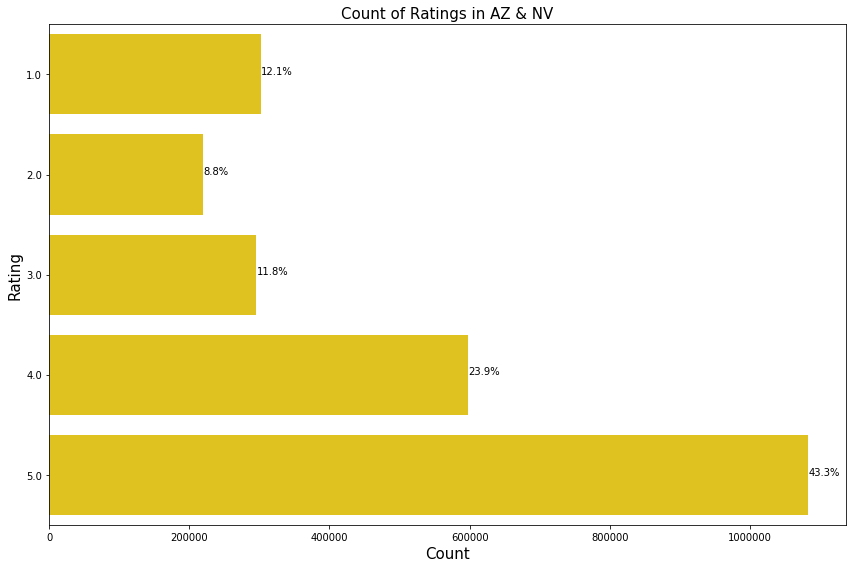

In [59]:
x = [5, 4, 3, 2, 1]
height = list(AZNV_df['stars_y'].value_counts())

plt.figure(figsize=(12,8))
ax = sns.countplot(y="stars_y", data=AZNV_df, color='gold')
plt.title('Count of Ratings in AZ & NV', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)

total = len(AZNV_df['stars_y'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.tight_layout()

plt.savefig('../img/AZNV_rating_count.png', dpi=350, transparent=True, alpha=10);
plt.show();

In [181]:
np.mean(AZNV_df['stars_y'])

3.789515477126627

min: 10
max: 5362


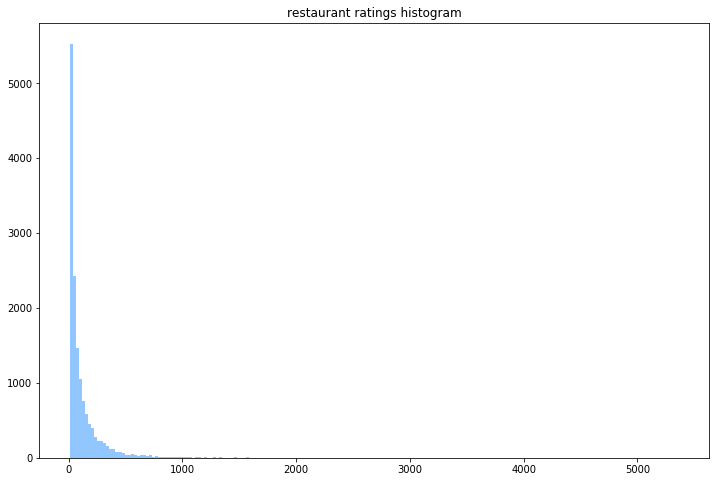

In [7]:
restaurant_rating_count = AZNV_df.groupby('business_id').count()

fig, ax = plt.subplots(1, figsize = (12, 8))
a = ax.hist(restaurant_rating_count['user_id'], bins=200)
a = ax.set_title('restaurant ratings histogram')

print('min: {}'.format(min(restaurant_rating_count['user_id'])))
print('max: {}'.format(max(restaurant_rating_count['user_id'])))

In [8]:
user_rating_count = AZNV_df.groupby('user_id').count()
restaurant_rating_count = AZNV_df.groupby('business_id').count()

rated_items = sum(restaurant_rating_count['user_id'])
print(rated_items)
num_items = len(restaurant_rating_count['user_id'])
print(num_items)
num_users = len(user_rating_count['business_id'])
print(num_users)

print('\nThe density of our data is {:.5f}'.format(rated_items/(num_items*num_users)))

1818490
14797
203359

The density of our data is 0.00060


# Other Notes

## Testing my computer - Phoenix, AZ

* To see if I could run this model on my computer in a reasonable amount of time

In [88]:
phoenix_review = review_by_statecity[review_by_statecity['state'] == 'AZ']
phoenix_review = phoenix_review[phoenix_review['city'] == 'Phoenix']
phoenix_review

state     city  positive_review  neutral_review  negative_review  \
1    AZ  Phoenix           361686           37247            24303   

   review_count positive_ratio  
1        423236           0.85

In [12]:
phoenix_reviews = master_df.groupby(['state', 'city', 'name_x', 'business_id'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
phoenix_reviews = phoenix_reviews.reset_index()
phoenix_reviews = phoenix_reviews[phoenix_reviews['state'] == 'AZ']
phoenix_reviews = phoenix_reviews[phoenix_reviews['city'] == 'Phoenix']
phoenix_reviews.head(10)


state     city                     name_x             business_id  \
30    AZ  Phoenix                    Bobby Q  VyVIneSU7XAWgMBllI6LnQ   
44    AZ  Phoenix            Pizzeria Bianco  pSQFynH1VxkfSmehRXlZWw   
54    AZ  Phoenix                Lux Central  OgJ0KxwJcJ9R5bUK0ixCbg   
58    AZ  Phoenix               La Santisima  frCxZS7lPhEnQRJ3UY6m7A   
60    AZ  Phoenix       The Arrogant Butcher  yNPh5SO-7wr8HPpVCDPbXQ   
61    AZ  Phoenix                       Cibo  9a3DrZvpYxVs3k_qwlCNSw   
62    AZ  Phoenix            Little Miss BBQ  Xg5qEQiB-7L6kGJ5F4K3bQ   
68    AZ  Phoenix  Lo-Lo's Chicken & Waffles  YPavuOh2XsnRbLfl0DH2lQ   
75    AZ  Phoenix       Matt's Big Breakfast  L2p0vO3fsS2LC6hhQo3CzA   
96    AZ  Phoenix              Chino Bandido  cHdJXLlKNWixBXpDwEGb_A   

    review_id  
30       2662  
44       2320  
54       2114  
58       2020  
60       2006  
61       2005  
62       1982  
68       1859  
75       1823  
96       1636

In [89]:
phoenix_df = master_df[master_df['state'] == 'AZ']
phoenix_df = phoenix_df[phoenix_df['city'] == 'Phoenix']
phoenix_df = phoenix_df.reset_index(drop=True)
phoenix_df.head()

business_id             name_x                 address     city  \
0  y1VInN5m3RbHU59kiQbmxA     Asi Es La Vida          3602 N 24th St  Phoenix   
1  CzqYP9VKJBzGLnp14naScA  Chelsea's Kitchen  3800 E Sky Harbor Blvd  Phoenix   
2  oBWcHgBk7qVj33LUdQa-rg    In-N-Out Burger     34850 N Valley Pkwy  Phoenix   
3  VINE7iA13oerzpSvnh40Pg     The Grove Cafe         7010 S 27th Ave  Phoenix   
4  OZC42gnhlJ_auXduDRfMoQ            Scratch           1011 N 3rd St  Phoenix   

  state postal_code   latitude   longitude  stars_x  review_count_x  is_open  \
0    AZ       85016  33.489537 -112.030474      4.0             249        1   
1    AZ       85034  33.435896 -111.998094      4.0             409        1   
2    AZ       85086  33.800488 -112.130006      4.0             127        1   
3    AZ       85041  33.382596 -112.117267      3.5              27        0   
4    AZ       85004  33.459054 -112.068953      3.0              41        0   

                                          attributes  \
0  {'RestaurantsTakeOut': 'True', 'RestaurantsGoo...   
1  {'Caters': 'False', 'Alcohol': 'u'full_bar'', ...   
2  {'RestaurantsDelivery': 'False', 'Alcohol': 'u...   
3  {'NoiseLevel': 'u'average'', 'GoodForKids': 'T...   
4  {'NoiseLevel': 'u'average'', 'HasTV': 'True', ...   

                                          categories  \
0                             [Mexican, Restaurants]   
1  [Cafes, Restaurants, Breakfast & Brunch, Ameri...   
2                  [Restaurants, Fast Food, Burgers]   
3                  [Restaurants, Breakfast & Brunch]   
4                              [French, Restaurants]   

                                               hours               review_id  \
0  {'Monday': '10:30-21:0', 'Tuesday': '10:30-21:...  81ZpSHeG2ZIOSpErccpyIQ   
1                                               None  -pYQHRMLjWJjvdcaMHNhpA   
2  {'Monday': '10:30-1:0', 'Tuesday': '10:30-1:0'...  QY8YuYEjqJNQPgKOuS_9LQ   
3     {'Saturday': '8:0-12:0', 'Sunday': '8:0-12:0'}  kdjGQdy87Xw8TalQa6Rk6g   
4  {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...  iBvdrnOxDbdvlp6AX-BjyQ   

                  user_id  stars_y  useful  funny  cool  \
0  WVTxk0-DxPKJ7TckvUx_dA      2.0       3      2     2   
1  WVTxk0-DxPKJ7TckvUx_dA      2.0       0      0     0   
2  JysF40STBTmx7h-sU1FHgg      4.0       0      0     0   
3  M4yYtAXehUzaHB1ghl6EXg      5.0       1      0     0   
4  M4yYtAXehUzaHB1ghl6EXg      3.0       0      0     0   

                                                text                 date  \
0  ENVIRONMENT - A more upscale Mexican restauran...  2014-11-08 16:35:04   
1  It's a nice place to sit and relax and chat wi...  2014-11-01 01:20:51   
2  Located on HWY17 on exit 223.  You'll pass thi...  2013-04-12 20:51:14   
3  This is the prime example why I always use Yel...  2013-04-16 16:41:02   
4  Let me start by saying I was happy with the fo...  2013-04-16 21:58:52   

  name_y  review_count_y        yelping_since  \
0  Yentl             121  2013-03-17 14:36:54   
1  Yentl             121  2013-03-17 14:36:54   
2   Luke             649  2010-09-18 18:45:01   
3  Peggy             411  2010-12-29 15:08:51   
4  Peggy             411  2010-12-29 15:08:51   

                                             friends  fans  average_stars  \
0  HwKsqxZ4CSMdVaRX-b0qiA, hwxt2bO8gSktMANU0jcpPQ...    11           3.60   
1  HwKsqxZ4CSMdVaRX-b0qiA, hwxt2bO8gSktMANU0jcpPQ...    11           3.60   
2  ms7gg62p6gEfc6-YHNaebQ, mxICOdig3rZ3Auer7j9iDw...    78           3.51   
3  dGUOe2TBchiGvU1BNkmTog, htiVdsiY_rBmJc65aZ3YAA...    29           3.77   
4  dGUOe2TBchiGvU1BNkmTog, htiVdsiY_rBmJc65aZ3YAA...    29           3.77   

   likes  compliments  elite_years  hotel?  positive_review  neutral_review  \
0    249           26            2       0             True           False   
1    249           26            2       0             True           False   
2   3185          624            8       0             True           False   

In [94]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor
from surprise import Reader
from surprise.model_selection import cross_validate

start = time.time()

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(phoenix_df[['user_id', 'business_id', 'stars_y']], reader)
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

gs.fit(data)

end = time.time()
print('this process took {:.3f} seconds'.format(end-start))

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

/Users/michaellin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/michaellin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



this process took 522.894 seconds
1.2370653472568665
{'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.4}


### Conclusion: Yes the model should run on my computer in a reasonable amount of time

2.4 million rows can run under 1 hour

## Choosing my dataset

* Pair down my dataset to just a couple of US states
* I chose to exclude restaurants from Canada
<br><br>
* Ideally, California or SF businesses would have been included in this dataset to be used as the dataset for a recommender system, however I can still make a recommender system as a proof of concept based on other US cities.

In [15]:
state_review_count.head(10)

state  review_id
0    NV    1316216
1    AZ    1182595
2    ON     572347
3    NC     272087
4    OH     226048
5    PA     203716
6    QC     137403
7    WI      93201
8    AB      63886
9    IL      28689

### Choose Nevada, Arizona, North Carolina, Ohio, Pennsylvania

* Based on top 5 US States with the largest number of reviews

In [ ]:
top5_states = ['NV', 'AZ', 'NC', 'OH', 'PA']
top5_state_df = master_df['state']

In [10]:
review_by_statecity.head(5)

state        city  positive_review  neutral_review  negative_review  \
0    NV   Las Vegas           989528          118729            61930   
1    AZ     Phoenix           361686           37247            24303   
2    ON     Toronto           288501           61571            24980   
3    AZ  Scottsdale           201330           18897             6799   
4    NC   Charlotte           166510           25275            16184   

   review_count positive_ratio  
0       1170187           0.85  
1        423236           0.85  
2        375052           0.77  
3        227026           0.89  
4        207969           0.80

In [11]:
state_filter_list = ['NV', 'AZ', 'ON', 'NC']
city_filter_list = ['Las Vegas', 'Phoenix', 'Toronto', 'Scottsdale', 'Charlotte']

top5_reviews = master_df.groupby(['state', 'city', 'name_x', 'business_id'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
top5_reviews = top5_reviews.reset_index()
top5_reviews = top5_reviews[top5_reviews['state'].isin(state_filter_list)]
top5_reviews = top5_reviews[top5_reviews['city'].isin(city_filter_list)]
top5_reviews.head()

state       city               name_x             business_id  review_id
0    NV  Las Vegas         Mon Ami Gabi  4JNXUYY8wbaaDmk3BPzlWw       8570
1    NV  Las Vegas     Bacchanal Buffet  RESDUcs7fIiihp38-d6_6g       8568
2    NV  Las Vegas         Wicked Spoon  K7lWdNUhCbcnEvI0NhGewg       6887
3    NV  Las Vegas   Hash House A Go Go  f4x1YBxkLrZg652xt2KR5g       5847
4    NV  Las Vegas  Gordon Ramsay BurGR  cYwJA2A6I12KNkm2rtXd5g       5575

In [12]:
state_filter_list = ['NV', 'AZ', 'ON', 'NC']
city_filter_list = ['Las Vegas', 'Phoenix', 'Toronto', 'Scottsdale', 'Charlotte']

top5_df = master_df[master_df['state'].isin(state_filter_list)]
top5_df = top5_df[top5_df['city'].isin(city_filter_list)]
top5_df = top5_df.reset_index(drop=True)
print('Shape of top5_df: {}'.format(top5_df.shape))
top5_df.head()

Shape of top5_df: (2403470, 35)


business_id                 name_x                address  \
0  LCb2moBNkcBto_32rmZJ5A             Echo Sushi      2036 Yonge Street   
1  9ET_RUNztevq4_OLAX80Gg            Café Boulud    60 Yorkville Avenue   
2  VBcmyBxAPcpzbbnPbFfttA  La Bettola di Terroni        106 Victoria St   
3  65IxMPJtsgMlG-fCJy7SAg            Sushi Place    1730 Bloor Street W   
4  YLc7Djf3GsC8IT84YkZMzw              Sukhothai  274 Parliament Street   

      city state postal_code   latitude  longitude  stars_x  review_count_x  \
0  Toronto    ON     M4S 1Z9  43.701275 -79.397533      3.5             164   
1  Toronto    ON     M4W 0A4  43.671921 -79.388922      3.5             229   
2  Toronto    ON     M5C 2B4  43.652200 -79.378155      3.5             128   
3  Toronto    ON     M6P 1B3  43.654966 -79.459246      3.5              75   
4  Toronto    ON     M5A 3A4  43.658405 -79.365754      4.0             390   

   is_open                                         attributes  \
0        1  {'RestaurantsPriceRange2': '2', 'GoodForKids':...   
1        1  {'GoodForMeal': '{'dessert': False, 'latenight...   
2        1  {'BikeParking': 'True', 'RestaurantsPriceRange...   
3        1  {'BikeParking': 'True', 'RestaurantsPriceRange...   
4        1  {'Ambience': '{'romantic': False, 'intimate': ...   

                                     categories  \
0  [Japanese, Sushi Bars, Buffets, Restaurants]   
1  [Food, Desserts, Cafes, Restaurants, French]   
2                  [Italian, Restaurants, Food]   
3           [Restaurants, Sushi Bars, Japanese]   
4                           [Thai, Restaurants]   

                                               hours               review_id  \
0  {'Tuesday': '17:0-22:30', 'Wednesday': '17:0-2...  b5xaVUMHi6eaelYJPoL8dg   
1  {'Monday': '6:30-22:0', 'Tuesday': '6:30-22:0'...  gQUFpVY1nX2SPUYVxR8hZw   
2                                               None  ChzgUDpd5Ueyo1iTzUk2Ww   
3  {'Monday': '16:30-22:30', 'Tuesday': '16:30-22...  g6ssZLiyEq6fvhAyyLXvvA   
4  {'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'...  hCaYFthmWwX8ftP_5pztGw   

                  user_id  stars_y  useful  funny  cool  \
0  2K62MJ4CJ19L8Tp5pRfjfQ      4.0       1      1     1   
1  2K62MJ4CJ19L8Tp5pRfjfQ      3.0       1      1     1   
2  2K62MJ4CJ19L8Tp5pRfjfQ      2.0       1      2     1   
3  2K62MJ4CJ19L8Tp5pRfjfQ      2.0       0      0     0   
4  2K62MJ4CJ19L8Tp5pRfjfQ      3.0       0      0     0   

                                                text                 date  \
0  We went on a Saturday night and the restaurant...  2016-06-27 03:46:24   
1  This review is specific to Summerlicious 2016\...  2016-08-31 21:05:19   
2  I am starting to develop a downward bias for I...  2016-08-31 20:49:04   
3  We were in the area on Sunday to walk in High ...  2017-04-25 16:38:54   
4  Went to Sukho Thai for a mid-week dinner with ...  2017-07-23 19:34:07   

  name_y  review_count_y        yelping_since  \
0  David              57  2014-11-27 22:36:00   
1  David              57  2014-11-27 22:36:00   
2  David              57  2014-11-27 22:36:00   
3  David              57  2014-11-27 22:36:00   
4  David              57  2014-11-27 22:36:00   

                                             friends  fans  average_stars  \
0  ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...     1            3.3   
1  ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...     1            3.3   
2  ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...     1            3.3   
3  ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...     1            3.3   
4  ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...     1            3.3   

   likes  compliments  elite_years  hotel?  positive_review  neutral_review  \
0    100           16            2       0             True           False   
1    100           16            2       0             True           False   
2    100           16            2       0             True           False   
3    100         

In [ ]:
#### top5 cities contain 2,403,470 reviews

min: 1
max: 1379


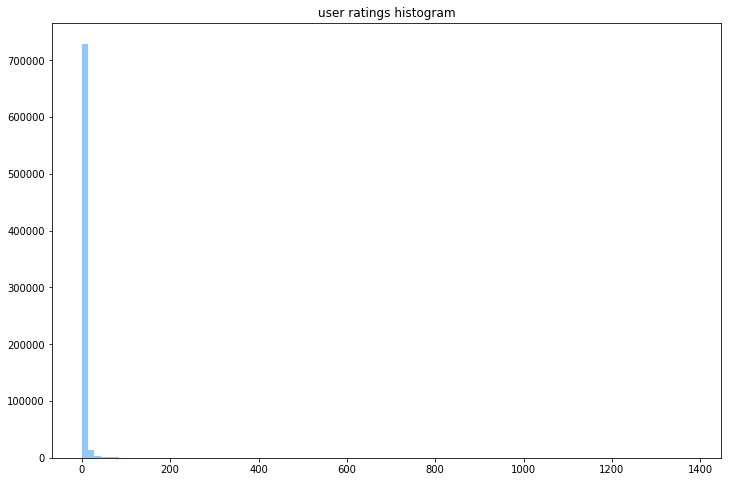

In [28]:
user_rating_count = top5_df.groupby('user_id').count()

fig, ax = plt.subplots(1, figsize = (12, 8))
a = ax.hist(user_rating_count['business_id'], bins=100)
a = ax.set_title('user ratings histogram')

print('min: {}'.format(min(user_rating_count['business_id'])))
print('max: {}'.format(max(user_rating_count['business_id'])))

In [34]:
user_rating_count.describe()

business_id         name_x        address           city  \
count  751986.000000  751986.000000  751986.000000  751986.000000   
mean        3.196163       3.196163       3.196163       3.196163   
std         9.480644       9.480644       9.480644       9.480644   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         3.000000       3.000000       3.000000       3.000000   
max      1379.000000    1379.000000    1379.000000    1379.000000   

               state    postal_code       latitude      longitude  \
count  751986.000000  751986.000000  751986.000000  751986.000000   
mean        3.196163       3.196163       3.196163       3.196163   
std         9.480644       9.480644       9.480644       9.480644   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         3.000000       3.000000       3.000000       3.000000   
max      1379.000000    1379.000000    1379.000000    1379.000000   

             stars_x  review_count_x        is_open     attributes  \
count  751986.000000   751986.000000  751986.000000  751986.000000   
mean        3.196163        3.196163       3.196163       3.185142   
std         9.480644        9.480644       9.480644       9.443590   
min         1.000000        1.000000       1.000000       0.000000   
25%         1.000000        1.000000       1.000000       1.000000   
50%         1.000000        1.000000       1.000000       1.000000   
75%         3.000000        3.000000       3.000000       3.000000   
max      1379.000000     1379.000000    1379.000000    1366.000000   

          categories          hours      review_id        stars_y  \
count  751986.000000  751986.000000  751986.000000  751986.000000   
mean        3.196163       3.042728       3.196163       3.196163   
std         9.480644       8.850166       9.480644       9.480644   
min         1.000000       0.000000       1.000000       1.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         3.000000       2.000000       3.000000       3.000000   
max      1379.000000    1301.000000    1379.000000    1379.000000   

              useful          funny           cool           text  \
count  751986.000000  751986.000000  751986.000000  751986.000000   
mean        3.196163       3.196163       3.196163       3.196163   
std         9.480644       9.480644       9.480644       9.480644   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         3.000000       3.000000       3.000000       3.000000   
max      1379.000000    1379.000000    1379.000000    1379.000000   

                date         name_y  review_count_y  yelping_since  \
count  751986.000000  751986.000000   751986.000000  751986.000000   
mean        3.196163       3.196163        3.196163       3.196163   
std         9.480644       9.480644        9.480644       9.480644   
min         1.000000       1.000000        1.000000       1.000000   
25%         1.000000       1.000000        1.000000       1.000000   
50%         1.000000       1.000000        1.000000       1.000000   
75%         3.000000       3.000000        3.000000       3.000000   
max      1379.000000    1379.000000     1379.000000    1379.000000   

             friends           fans  average_stars          likes  \
count  751986.000000  751986.000000  751986.000000  751986.000000   
mean        3.196163       3.196163       3.196163       3.196163   
std         9.480644       9.480644       9.480644  

In [35]:
print('user rating count: {}'.format(len(user_rating_count['business_id'])))
print('user rating count = 1 rating: {}'.format(len(user_rating_count[user_rating_count['business_id']==1])))
print('user rating count < 3 rating: {}'.format(len(user_rating_count[user_rating_count['business_id']<3])))
print('user rating count < 3 rating ratio: {:.2%}'.format(len(user_rating_count[user_rating_count['business_id']<3])/len(user_rating_count['business_id'])))

user rating count: 751986
user rating count = 1 rating: 433199
user rating count < 3 rating: 558611
user rating count < 3 rating ratio: 74.28%


min: 3
max: 8570


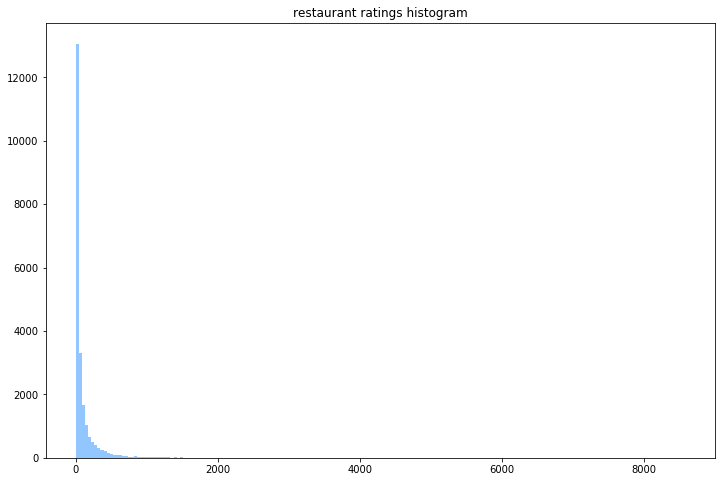

In [17]:
restaurant_rating_count = top5_df.groupby('business_id').count()

fig, ax = plt.subplots(1, figsize = (12, 8))
a = ax.hist(restaurant_rating_count['user_id'], bins=200)
a = ax.set_title('restaurant ratings histogram')

print('min: {}'.format(min(restaurant_rating_count['user_id'])))
print('max: {}'.format(max(restaurant_rating_count['user_id'])))

In [18]:
print('restaurant rating count: {}'.format(len(restaurant_rating_count['user_id'])))
print('restaurant rating count with 3 rating: {}'.format(len(restaurant_rating_count[restaurant_rating_count['user_id']==3])))
print('restaurant rating count with 3 rating ratio: {:.2%}'.format(len(restaurant_rating_count[restaurant_rating_count['user_id']==3])/len(restaurant_rating_count['user_id'])))

print('restaurant rating count with 4 rating: {}'.format(len(restaurant_rating_count[restaurant_rating_count['user_id']==4])))
print('restaurant rating count with 5 rating: {}'.format(len(restaurant_rating_count[restaurant_rating_count['user_id']==5])))

restaurant rating count: 22547
restaurant rating count with 3 rating: 1128
restaurant rating count with 3 rating ratio: 5.00%
restaurant rating count with 4 rating: 932
restaurant rating count with 5 rating: 775


In [19]:
rated_items = sum(restaurant_rating_count['user_id'])
print(rated_items)
num_items = len(restaurant_rating_count['user_id'])
print(num_items)
num_users = len(user_rating_count['business_id'])
print(num_users)

print('\nThe density of our data is {:.5f}'.format(rated_items/(num_items*num_users)))

2403470
22547
751986

The density of our data is 0.00014


### Look at dataset for users above 1, 2, 3, 4, 5 total user reviews

In [27]:
len(user_rating_count['business_id'])

751986

In [25]:
len(user_rating_count[user_rating_count['business_id']>1])

318787

In [28]:
len(user_rating_count[user_rating_count['business_id']>2])

193375

In [29]:
len(user_rating_count[user_rating_count['business_id']>3])

134242

In [30]:
len(user_rating_count[user_rating_count['business_id']>4])

100382

In [31]:
len(user_rating_count[user_rating_count['business_id']>5])

78898

### Create base model based on mean or median

### First model based on Similiarity Based Recommender Model (SVD)

In [116]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor
from surprise import Reader
from surprise.model_selection import cross_validate

start = time.time()

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(top5_df[['user_id', 'business_id', 'stars_y']], reader)
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

gs.fit(data)

end = time.time()
print('this process took {:.3f} seconds'.format(end-start))

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

/Users/michaellin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/michaellin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/michaellin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/michaellin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Use

this process took 3130.908 seconds
1.2266309393970085
{'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.4}


In [119]:
filename = ('../model/7-21-top5-model-1.p')
pickle.dump(gs, open(filename, 'wb'))

### Future

* LSTM
* Matrix Factorization
* Deep Learning

### content based - get price, get food , service ratings